# Обучение FC-декодера
Здесть предствлено обучение декодера. Процесс такой же, как и в train_decoder.py, но с описанием и построением графиков

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import imageio
from matplotlib import pyplot as plt
%matplotlib inline

from decoder import Decoder, LinearBnRelu

from IPython import display
from tqdm import tqdm
import time


Загружаем предпосчитанные эмбеддинги (получены сетью `facenet`)

In [2]:
EMB_COUNT = 202599
EMB_SIZE = 128
embeddings = np.ndarray(shape=(EMB_COUNT,EMB_SIZE))

with open('embeddings_float.txt') as f:
    for i, line in enumerate(f):
        embeddings[i, :] = np.array(list(map(np.float64, line.strip()[4:].split())))

In [24]:
decoder = Decoder(in_features=EMB_SIZE, out_features=160*160*3)
decoder.load_state_dict(torch.load('decoder_state'))

In [4]:
train_indices = np.random.choice(range(0, EMB_COUNT), size=int(EMB_COUNT * 0.9), replace=False)
train_indices.sort()
test_indices = np.array(list(set(range(0, EMB_COUNT)) - set(train_indices)))
test_indices.sort()
test_indices[:10]

array([ 6, 23, 31, 36, 46, 49, 61, 65, 67, 79])

In [5]:
def get_batch(indices, embeddings, batch_size=1, img_dir='img_align_celeba_160', shuffle=True):
    if shuffle:
        indices_shufled = np.random.permutation(indices)
    else:
        indices_shufled = indices
     
    for start in range(0, len(indices), batch_size):
        batch_indices = indices_shufled[start: start + batch_size]
        
        emb_batch = np.ndarray((batch_size, EMB_SIZE))
        img_batch = np.ndarray((len(batch_indices), 160*160*3))
        
        for i, img_id in enumerate(batch_indices):
            img_path = 'img_align_celeba_160/{0:06d}.jpg'.format(img_id + 1)
            img_batch[i] = np.array(imageio.imread(img_path) / 255).reshape(1, -1)
            emb_batch[i] = embeddings[img_id]
        yield img_batch, emb_batch

In [6]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Обучаем модель
* Для оптимизации используем метод `Adam`
* Функция потерь `binary_cross_entropy`
* На каждой итерации строится график функции потерь (сглаженный окном в 100 итераций, чтобы сгладить скачки), а также из тестового набора выбирается случайный эмбеддинг и строится восстановленная по нему картинка, чтобы можно было наблюдать процесс изменения качества)

KeyboardInterrupt


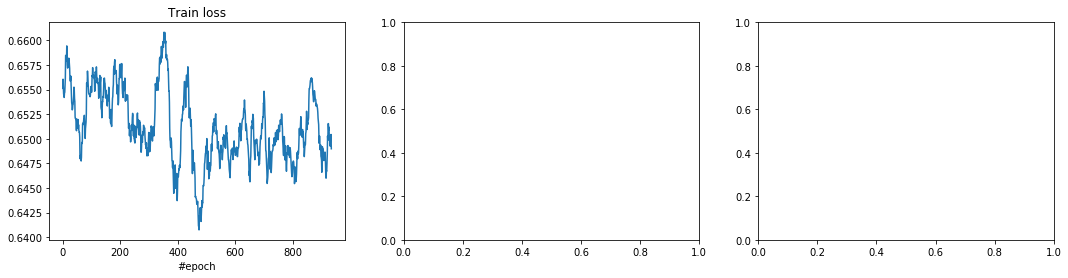

In [25]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)

best_params = {}
best_epoch = 0
train_loss = []
test_loss = []
min_mse = np.inf

train_loss_iterations = []
test_loss_epochs = []

n_epochs = 100
batch_size = 5
test_batch_size = 1
iteration = 0
try:
    for epoch in range(n_epochs):
        start_time = time.time()

        for img_batch, emb_batch in tqdm(get_batch(train_indices, embeddings, batch_size), 
                                         desc='training {} epoch'.format(epoch), 
                                         total=len(train_indices) // batch_size):
            decoder.train(True)
            iteration += 1
            img_batch = Variable(torch.FloatTensor(img_batch))
            emb_batch = Variable(torch.FloatTensor(emb_batch))
            decoded = decoder(emb_batch)
            loss = F.binary_cross_entropy(decoded, img_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_iterations.append(loss.data.numpy()[0])
            del img_batch, emb_batch
            
            if iteration % 1 == 0:
                display.clear_output(wait=True)
                f, ax = plt.subplots(1, 3, figsize=(18, 4))

                ax[0].set_title("Train loss")
                ax[0].set_xlabel("#epoch")
                if len(train_loss_iterations) > 50:
                    ax[0].plot(running_mean(train_loss_iterations, 50), label='train loss')
                else:
                    ax[0].plot(train_loss_iterations, label='train loss')

                decoder.train(False)
                emb_id = np.random.choice(test_indices)
                emb_var = Variable(torch.FloatTensor(embeddings[emb_id:emb_id+1]))
                img = decoder(emb_var)
                img_orig = imageio.imread('img_align_celeba_160/{0:06d}.jpg'.format(emb_id + 1)) / 255
                test_loss = F.binary_cross_entropy(img, Variable(torch.FloatTensor(img_orig.reshape(1, -1))))
                img = img.data.numpy().reshape(160, 160, 3)
                
                
                
                ax[1].imshow(img)
                ax[2].imshow(img_orig)

                
                plt.show()
                del img, img_orig
                
                print("  training loss (in-iteration): \t{:.6f}".format(train_loss_iterations[-1]))
                print("  testing loss (in-iteration): \t{:.6f}".format(test_loss.data.numpy()[0]))
                if len(test_loss_epochs) > 0:
                    print("  validation loss (in-epoch): \t{:.6f}".format(test_loss_epochs[-1]))

except KeyboardInterrupt:
    # torch.save(decoder.state_dict(), 'decoder_state')
    print('KeyboardInterrupt')


## Сохраняем состояния

In [26]:
torch.save(decoder.state_dict(), 'decoder_state')
torch.save(decoder, 'decoder_model')

C:\Users\Uchayder\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Uchayder\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type LinearBnRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
